In [ ]:
!pip install git+https://github.com/kaanaksit/odak.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kaanaksit/odak.git to /tmp/pip-req-build-_zh600v_
  Running command git clone -q https://github.com/kaanaksit/odak.git /tmp/pip-req-build-_zh600v_


In [ ]:
import odak
import torch 
import numpy as np 
import odak.learn.raytracing as ODL
import matplotlib.pyplot as plt
import math
import odak.raytracing as raytracer
import odak.tools as tools
import odak.raytracing as raytracer
import torch.nn as nn
from odak.raytracing.ray import create_ray
import cv2
from PIL import Image
import sys
import torch.optim as optim
from torchvision import transforms
from torch.nn import Module
import math

In [ ]:

class aperture_array():

  def __init__(self, device):
    self.device = device
    
    self.init_light_sources()
    self.init_aperture_array()
    self.init_detector()
    # self.transform_image()
    

  def transform_image(self, image):
    transform =transforms.Compose([
        transforms.Resize((20, 30)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
        
    ])
    normalised_image = transform(image).view(-1,1).to(self.device)
    
    return normalised_image

  
  def init_light_sources(self, dimensions=[0.01, 0.015], pixel_count=[20, 30], Z=0.):
      x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
      y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
      X, Y = torch.meshgrid(x, y, indexing='ij')
      self.light_source_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
      self.light_source_locations[:, :, 0] = X
      self.light_source_locations[:, :, 1] = Y
      self.light_source_locations[:, :, 2] = Z
      
      
  def init_aperture_array(self, dimensions=[0.01, 0.015], pixel_count=[20, 30], Z=0.01):
        x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
        y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
        X, Y = torch.meshgrid(x, y, indexing='ij')
        self.aperture_array_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
        self.aperture_array_locations[:, :, 0] = X
        self.aperture_array_locations[:, :, 1] = Y
        self.aperture_array_locations[:, :, 2] = Z
        self.aperture_array = torch.rand(X.shape[0], X.shape[1], requires_grad=True, device=self.device) 

        return self.aperture_array
        
        
  def init_detector(self, dimensions=[0.01, 0.015], size=[20, 30], Z=0.01):
        
        point = torch.tensor([0., 0., Z]).to(self.device)
        self.detector_surface = odak.learn.raytracing.define_plane(point)
        
        
  def intersection_points_to_image(self, points, amplitudes, threshold, norm_image):
   
        Points_data= norm_image * amplitudes
        detector = torch.zeros_like(Points_data).to(self.device)
        array_locations = self.aperture_array_locations.view(-1, 3)

        for idx, point in enumerate(points):
          
      
          dist_btwn_array_npoint = torch.sqrt(torch.sum((array_locations-point)**2, dim=1))
          min_dist_idx  = torch.argmin(dist_btwn_array_npoint)
          min_dist = torch.min(dist_btwn_array_npoint)

          if min_dist < (math.sqrt(2) * threshold):
            detector[min_dist_idx] = Points_data[idx]
            
        detector= detector.view(20, 30)
        return detector
  
  def forward(self, array, image):
        light_source_locations = self.light_source_locations.view(-1, 3)

        aperture_array_locations = self.aperture_array_locations.view(-1, 3)

        detector_image  = torch.zeros(20, 30).to(self.device)
        pixel_pitch = torch.sqrt(torch.sum((aperture_array_locations[1] - aperture_array_locations[0])**2, dim =0)).to(self.device)

        aperture_array = array.view(-1,1)
        self.img = image
        self.norm_img = self.transform_image(image) #size(600,1)
        
        for light_source_location in light_source_locations:
            rays_from_light_source = odak.learn.raytracing.create_ray_from_two_points(light_source_location, aperture_array_locations)

             # calculating intersection points
            intersection_normals_w_detector, _ = odak.learn.raytracing.intersect_w_surface(rays_from_light_source, self.detector_surface)
            intersection_points_w_detector = intersection_normals_w_detector[:, 0]
            
            
          # Getting the image seen on the image plane
            detector_image += self.intersection_points_to_image(
                                                                intersection_points_w_detector,
                                                                aperture_array, 
                                                                pixel_pitch,
                                                                self.norm_img
                                                              )  
        return detector_image

  def compute_loss(self, output , target):
    loss = torch.nn.MSELoss()(output, target)

    return loss
            
  def optimize(self):
        
        # 
        target= self.norm_img.view(20,30) #size(20,30)

        array = self.aperture_array.view(-1,1)
        array_loc = self.aperture_array_locations

        model = [nn.Parameter(array)]
       
        optimiser= torch.optim.SGD(model,lr = 0.001,momentum=0.9)
        epochs= 100

        for epoch in range(0, epochs+1):
          optimiser.zero_grad()
          
          output=self.forward(model[0], self.img)
          loss = self.compute_loss(output,target)
            
          loss.backward()
          optimiser.step()

          print('Epoch: ', epoch,' ,Loss: ', loss)

        return model, output
  
def main():
    device = torch.device('cuda')
    apertures = aperture_array(device=device)
    result = apertures.optimize()
    return True







## Calling the module and setting the device to 'cuda'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Aperture_RT= aperture_array(device)

# Retriving test Image

In [63]:

img_G = Image.open('/content/drive/MyDrive/Colab Notebooks/IP Labs/Images/Lenna.png').convert('L')

array = Aperture_RT.init_aperture_array()# initial value of the aperture array yet to be optimised


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((20, 30)),
    transforms.Normalize((0.5), (0.5))
])

resize_image = transform(img_G).to(device)
ray_traced_image= Aperture_RT.forward(array,img_G)


Text(0.5, 1.0, 'Image ray traced through array')

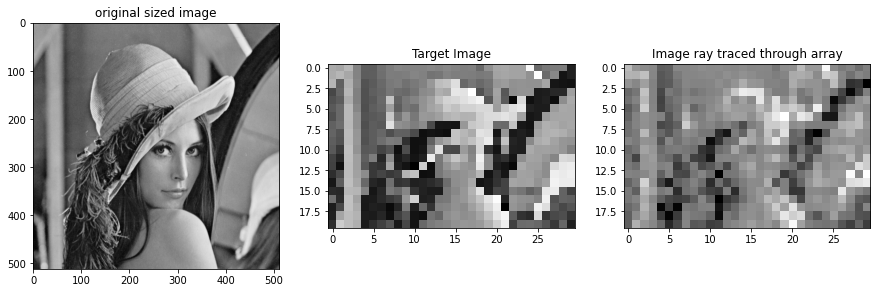

In [64]:
fig , axes=plt.subplots(1,3, figsize =(15, 15))

axes[0].imshow(img_G, cmap='gray')
axes[0].set_title('original sized image')

axes[1].imshow(resize_image.cpu().squeeze(), cmap='gray')
axes[1].set_title('Target Image')

axes[2].imshow(ray_traced_image.detach().cpu().numpy()*255, cmap='gray')
axes[2].set_title('Image ray traced through array')

In [65]:
Loss = Aperture_RT.compute_loss(ray_traced_image, resize_image)
print('The initial loss is: ',Loss)

The initial loss is:  tensor(11092.8398, device='cuda:0', grad_fn=<MseLossBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 20, 30])) that is different to the input size (torch.Size([20, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# Optimising the array 

In [ ]:
# optim = Aperture_RT.optimize()


Epoch:  0  ,Loss:  tensor(0.1543, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  1  ,Loss:  tensor(0.1542, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  2  ,Loss:  tensor(0.1540, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  3  ,Loss:  tensor(0.1538, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  4  ,Loss:  tensor(0.1535, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  5  ,Loss:  tensor(0.1532, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  6  ,Loss:  tensor(0.1528, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  7  ,Loss:  tensor(0.1523, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  8  ,Loss:  tensor(0.1518, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  9  ,Loss:  tensor(0.1513, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  10  ,Loss:  tensor(0.1508, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  11  ,Loss:  tensor(0.1502, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  12  ,Loss:  tensor(0.1496, device='cuda:0'

In [ ]:
# save optimised array
path="/content/drive/MyDrive/Colab Notebooks/MASTERS PROJECT /Models/{optim_array.pt}"
torch.save(optim[0][0], path)

In [44]:
# Load Optimised array
path="/content/drive/MyDrive/Colab Notebooks/MASTERS PROJECT /Models/{optim_array.pt}"
optim_array  = torch.load(path)


In [67]:
optimised_image =Aperture_RT.forward(optim_array,img_G)

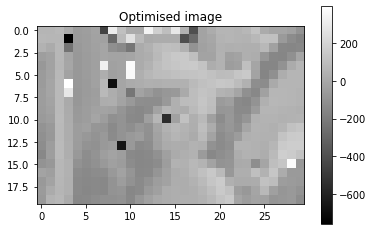

In [73]:
plt.imshow((optimised_image.detach().cpu().numpy()*255).astype(np.float32), cmap='gray')
plt.title('Optimised image')
plt.colorbar()

In [69]:
# calculating error between ray traced image and optimised array
Loss = Aperture_RT.compute_loss(optimised_image, resize_image.squeeze())
print('The loss after optimisation is: ',Loss)

The loss after optimisation is:  tensor(0.1255, device='cuda:0', grad_fn=<MseLossBackward0>)


## Using Optimised array for another image

In [60]:
test_image = Image.open('/content/Test_image.png').convert('L')
resized_im = test_image.resize((30,20))
ray_traced_im =Aperture_RT.forward(optim_array,test_image)


Text(0.5, 1.0, 'Image ray traced with optimised array')

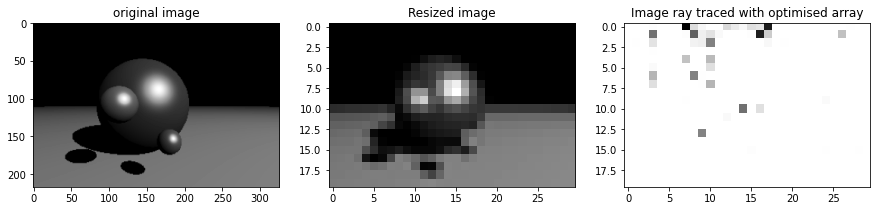

In [70]:
fig , axes=plt.subplots(1,3, figsize =(15, 15))

axes[0].imshow(test_image, cmap='gray')
axes[0].set_title('original image')

axes[1].imshow(resized_im, cmap='gray')
axes[1].set_title('Resized image')

axes[2].imshow(ray_traced_im.detach().cpu().numpy()*255, cmap='gray')
axes[2].set_title('Image ray traced with optimised array')